In [1]:
import feedparser, re, string, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
from collections import Counter
from dateutil.relativedelta import relativedelta
from wordcloud import WordCloud
from nltk.corpus import stopwords, words as nltk_words
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.collocations import *

In [2]:
def load_eprint_df(query = 'cat:hep-th', max_step_results = 500, pub_window = relativedelta(years = 1)):
    "Read eprint data into a Pandas DataFrame iteratively through the arxiv API."
    eprint_df = pd.DataFrame()    
    min_pub_date = pd.to_datetime('today') - pub_window
    start_entry = 0
    while True:
        # Request data from arxiv API feed until success
        while True:
            url = 'http://export.arxiv.org/api/query?search_query={}&sortBy=submittedDate&sortOrder=descending&start={}&max_results={}'.format(query, start_entry, max_step_results)
            data = feedparser.parse(url)
            if len(data.entries):
                break
            sleep(0.1)
        # Create new DataFrame and append to old one
        new_eprint_df = pd.DataFrame(data = data.entries)
        if not "published" in new_eprint_df.columns:
            break
        pub_dates = new_eprint_df.published.apply(pd.to_datetime)
        in_time_window = pub_dates >= min_pub_date
        eprint_df = eprint_df.append(new_eprint_df[in_time_window], ignore_index = True)
        start_entry += max_step_results
        if np.count_nonzero(in_time_window) < in_time_window.size:
            break
    return eprint_df

In [3]:
def get_words(text, stop_words, punc_trans):
    "Remove LaTeX tags, and extra whitespace, stopwords, and non-alphanumeric \
    characters. Make all lower case."
    text = re.sub(r'([^\\])\$(.*?)([^\\])\$', "", text)
    text = re.sub('\\\\[\'"]', '', text)
    text = re.sub('\s\s*', ' ', text)
    tokens = word_tokenize(text)
    words = []
    for word in tokens:
        word = word.lower()
        word = word.translate(punc_trans)
        if word.isalpha() and not word in stop_words:
            words.append(word)
    
    return words

In [4]:
def get_common_ngrams(words, bigram_measures, trigram_measures, freq_threshold = 5):
    "Determine most likely and common bigrams and trigrams."
    common_ngrams = []

    bigram_finder = BigramCollocationFinder.from_words(words)
    bigram_finder.apply_freq_filter(freq_threshold)
    common_ngrams.append([x[0] for x in bigram_finder.score_ngrams(bigram_measures.pmi)])

    
    trigram_finder = TrigramCollocationFinder.from_words(words)
    trigram_finder.apply_freq_filter(freq_threshold)
    common_ngrams.append([x[0] for x in trigram_finder.score_ngrams(trigram_measures.pmi)])
    
    return common_ngrams

In [5]:
def normalize_words(word_list, common_ngrams, porter, eng_word_stems):
    "Group bigrams and trigrams into new words, and remove stemmed colloquial \
    English words, leaving only technical terms."
    N = len(common_ngrams) + 1
    norm_words = []
    i = 0
    while i < len(words):
        j = N
        while j > 1:
            if tuple(norm_words[i:i + j]) in common_ngrams[j - 2]:
                norm_words.append(''.join(words[i:i + j]))
                i += j
                break
            j -= 1
        if j == 1:
            stem = porter.stem(words[i])
            if not stem in eng_word_stems:
                norm_words.append(words[i])
            i += 1
    
    return norm_words

In [6]:
# Initialize libraries
sns.set();
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('words');

[nltk_data] Downloading package punkt to /Users/ross/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ross/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/ross/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
# Obtain 1 year of hep-th arvix eprint data and save
eprint_df = load_eprint_df(query = 'cat:hep-th', max_step_results = 500, pub_window = relativedelta(years = 1))
eprint_df.to_csv("eprint_df.csv")

In [8]:
# Initialize helper variables
stop_words = set(stopwords.words('english'))
punc_trans = str.maketrans('', '', string.punctuation)

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

porter = PorterStemmer()
eng_word_stems = set(porter.stem(x) for x in nltk_words.words())

In [9]:
# Get normalized word counts for eprint abstracts. Use frequency threshold of 5
norm_word_counts = np.empty(eprint_df.shape[0], dtype = Counter)

for i in range(eprint_df.shape[0]):
    text = eprint_df.summary[i]
    words = get_words(text, stop_words, punc_trans)
    common_ngrams = get_common_ngrams(words, bigram_measures, trigram_measures, freq_threshold = 5)
    norm_words = normalize_words(words, common_ngrams, porter, eng_word_stems)
    norm_word_counts[i] = Counter(norm_words)

# Add normalized word counts to DataFrame
eprint_df["norm_words"] = pd.Series(norm_word_counts, index = eprint_df.index)

In [10]:
# Extract most common normalized words and their frequencies
words, total_freqs = zip(*eprint_df.norm_words.sum().most_common())

# Create new DataFrame from most common normalized words and their frequencies
norm_word_counts_df = pd.DataFrame(data = list(total_freqs), index = list(words), columns = ["total"])

# Send DataFrame through a bandpass filter removing least common words, and 
# extraordinarily (likely not technical terms) common ones
norm_word_counts_df = norm_word_counts_df[norm_word_counts_df.total > 10]
norm_word_counts_df = norm_word_counts_df[norm_word_counts_df.total < norm_word_counts_df.total.mean() + norm_word_counts_df.total.std()]

In [11]:
# Extract most common normalized words and their frequencies for successive 6 month windows, 
# each offset by 1 week. Add these as new columns to DataFrame
pub_dates = eprint_df.published.apply(pd.to_datetime)
today = pd.to_datetime('today')
window = relativedelta(months = 6)
offset = relativedelta(weeks = 1)
while today >= pub_dates.min() + window:
    offset_mask = (pub_dates >= today - window) & (pub_dates <= today)
    offset_norm_word_counts = eprint_df.norm_words[offset_mask].sum()
    offset_words, offset_freqs = zip(*list(offset_norm_word_counts.items()))
    norm_word_counts_df[today] = pd.Series(list(offset_freqs), index = list(offset_words))
    today -= offset

# Fill null cells with zeroes and reverse column order, so left to right increases in time. Save to .csv
norm_word_counts_df = norm_word_counts_df.fillna(0).iloc[:, ::-1]
norm_word_counts_df.to_csv("norm_word_counts_df.csv")

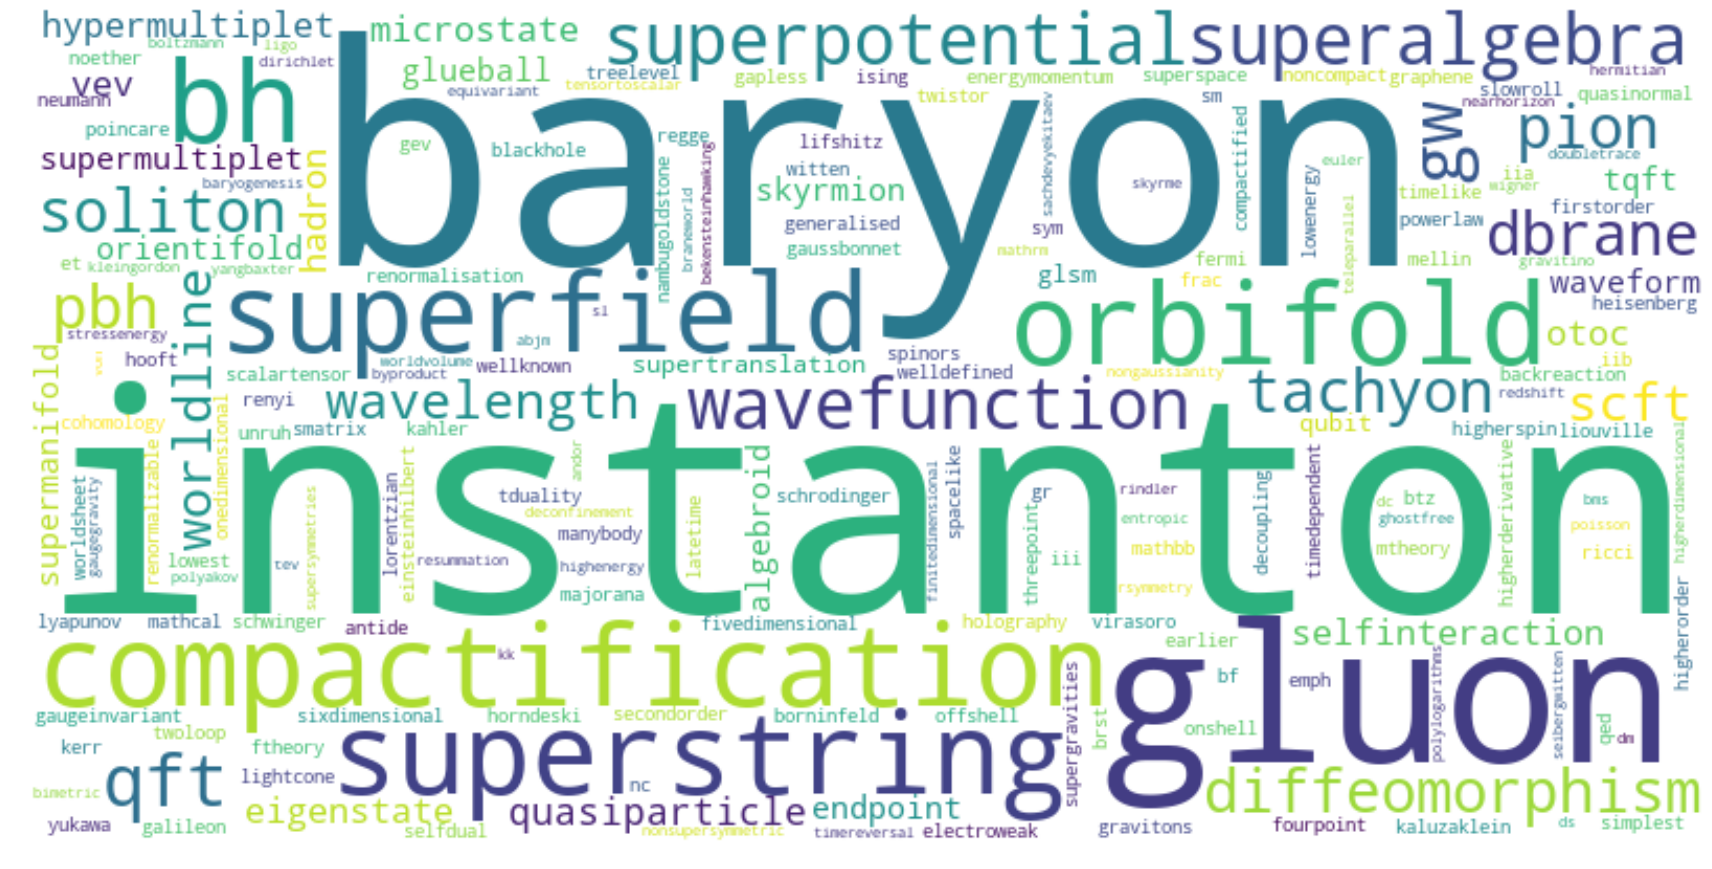

In [12]:
# Generate a word cloud of the 200 most common words for the full 1 year period
norm_text = ' '.join(norm_word_counts_df.index)

wordcloud = WordCloud(background_color = 'white',
                      max_words = 200,
                      width = 800,
                      height = 400).generate(norm_text)

fig, ax = plt.subplots(figsize = (30, 20))
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.axis("off")
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('wordcloud.png', dpi = 100, bbox_inches='tight')

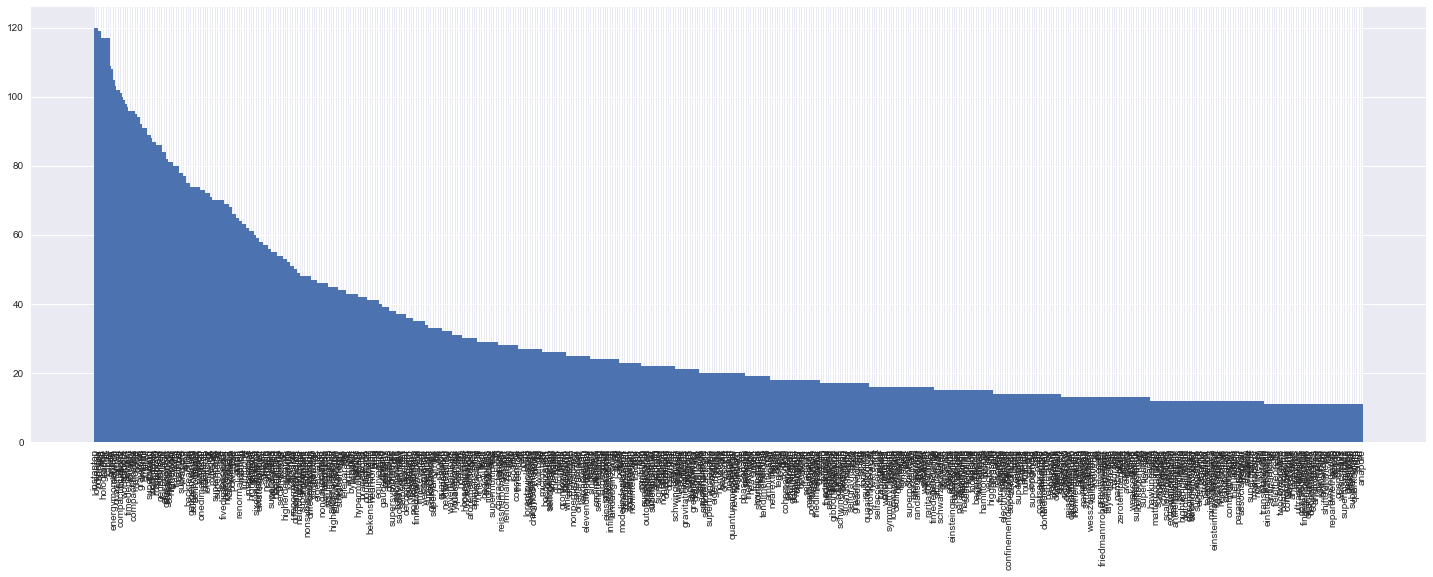

In [13]:
# Plot a bar graph (essentially a histogram) for the word frequencies over the full 1 year period
labels = norm_word_counts_df.index
freqs = norm_word_counts_df.total.as_matrix()

indexes = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (25, 8))
ax.bar(indexes, freqs, width = 1)
ax.set_xticks(indexes)
ax.set_xticklabels(labels, rotation = 90)
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('histogram.png', dpi = 100, bbox_inches='tight')

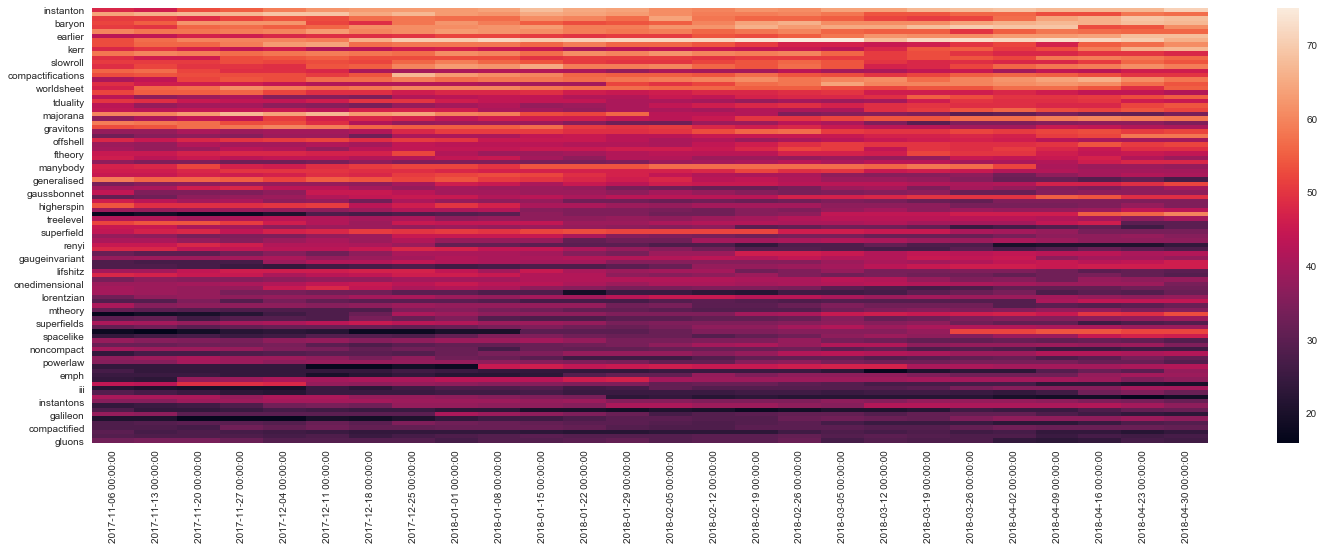

In [14]:
# Plot a (truncated) heatmap for the word frequencies in all 6 month periods
fig, ax = plt.subplots(figsize = (25, 8))
sns.heatmap(norm_word_counts_df.drop(columns = "total").iloc[:100], linewidths = 0, annot = False, ax = ax)
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('heatmap_freq.png', dpi = 100, bbox_inches='tight')

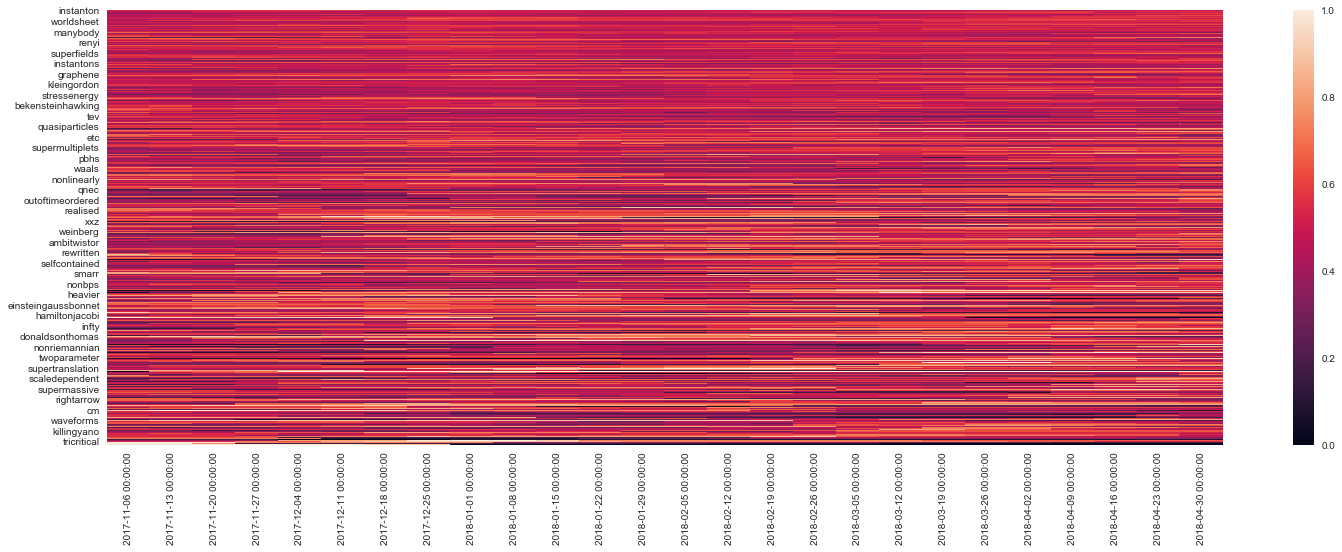

In [15]:
# Plot a (truncated) heatmap of fractions of each word's total 1 year frequency, in all 6 month periods
fig, ax = plt.subplots(figsize = (25, 8))
norm_word_count_fracs_df = norm_word_counts_df.div(norm_word_counts_df.total, axis = 0)
sns.heatmap(norm_word_count_fracs_df.drop(columns = "total").iloc[:1000], linewidths = 0, annot = False, ax = ax)
plt.show()
fig.set_size_inches(18.5, 10.5)
fig.savefig('heatmap_frac.png', dpi = 100, bbox_inches='tight')